In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in all the words

words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}

print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [61]:
 # built the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

X, Y = [], [] # input X and label Y

for w in words:
    #print(w)

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [108]:
# converting the dataset part to a function to better allow for training, validation, test splits

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], [] # input X and label Y

    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])

Xtest, Ytest = build_dataset(words[n2:])
                         

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [109]:
C = torch.randn((27,2))
C

tensor([[ 3.7959e-01,  1.0409e+00],
        [ 5.1529e-01, -1.4449e-01],
        [-5.2241e-01,  5.4477e-01],
        [ 4.3572e-01, -1.1622e+00],
        [-6.0056e-01,  4.3530e-01],
        [ 3.4629e-01, -2.4076e+00],
        [-8.5376e-01, -3.3492e-01],
        [ 2.0061e-03,  2.3139e+00],
        [-1.4365e+00,  1.4028e+00],
        [-2.2243e+00,  1.1306e+00],
        [ 4.9494e-01, -1.2492e+00],
        [-1.8729e+00,  1.2546e+00],
        [-2.0675e-01, -6.7014e-02],
        [-1.4335e+00,  1.6419e-02],
        [-2.8249e-01,  3.3766e-02],
        [-4.5808e-01,  7.7068e-01],
        [-5.5110e-01, -2.0865e-01],
        [ 1.8177e-01,  2.9948e-01],
        [ 7.7198e-01, -4.1280e-01],
        [ 1.3631e-01,  4.9826e-01],
        [-9.7438e-01,  1.1201e-01],
        [-2.7406e+00,  7.4128e-01],
        [ 1.0517e-01,  2.8946e-01],
        [ 7.8099e-01,  6.9553e-01],
        [ 6.0119e-01,  6.6045e-01],
        [ 7.3359e-01,  2.3855e-01],
        [ 1.2450e+00, -8.5465e-01]])

In [110]:
C[5]

tensor([ 0.3463, -2.4076])

In [111]:
#F.one_hot(torch.tensor(5), num_classes=27).float() @ C 

In [112]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [113]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [114]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [115]:
h

tensor([[ 0.6381, -0.7082, -0.8560,  ..., -0.4758, -0.5344, -0.8575],
        [ 0.9973, -0.8413,  0.9913,  ..., -0.4969, -0.7406,  0.9867],
        [ 0.9914,  0.2217, -0.9998,  ...,  0.9997, -0.9750, -0.9507],
        ...,
        [ 0.5243,  0.4637, -0.0893,  ...,  0.8984,  0.9897, -0.9997],
        [ 0.6882,  0.2662,  0.9796,  ..., -0.6267,  0.9954, -0.9689],
        [ 0.9331, -0.3075, -0.8125,  ...,  0.9808,  0.7149, -0.9985]])

In [116]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [117]:
logits = h @ W2 + b2

In [118]:
logits.shape

torch.Size([228146, 27])

In [119]:
counts = logits.exp()

In [120]:
prob = counts/ counts.sum(1, keepdims=True)

In [121]:
prob.shape

torch.Size([228146, 27])

In [122]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [43]:
# --------------------- properly arranged now ------------------------

In [181]:
Xtrain.shape, Ytrain.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [182]:
g = torch.Generator().manual_seed(2147483647) # for reproduciblity
C = torch.randn((27,10), generator = g)
W1 = torch.randn((30, 200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200, 27), generator =g)
b2 = torch.randn(27, generator =g)
parameters = [C, W1, b1, W2, b2]

In [183]:
sum(p.nelement() for p in parameters) # number of parameters in total 

11897

In [184]:
for p in parameters:
    p.requires_grad = True

In [185]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [186]:
lri = []
lossi = []
stepi = []

In [187]:

for i in range(200000):

    # minibatch construct 
    ix = torch.randint(0, Xtrain.shape[0], (32,))

    # forward pass

    emb = C[Xtrain[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytrain[ix])
    #print(loss.item())
    
    # backward pass
    
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    #lr = 0.01
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    #lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.0680150985717773


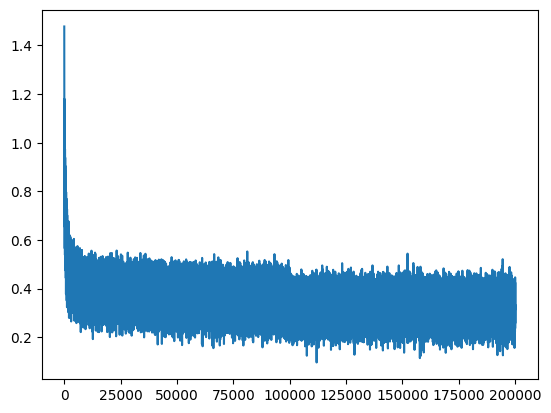

In [188]:
plt.plot(stepi,lossi)

In [189]:
emb = C[Xtrain] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytrain)
loss

tensor(2.1270, grad_fn=<NllLossBackward0>)

In [190]:
emb = C[Xval] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Yval)
loss

tensor(2.1611, grad_fn=<NllLossBackward0>)

In [ ]:
# training split, validation split and test split

# training split -> 80% usually and to train the model 
# validation split -> 10% usually and to tune the hyperparatmeter
# test split -> 10% usually and to test the final model




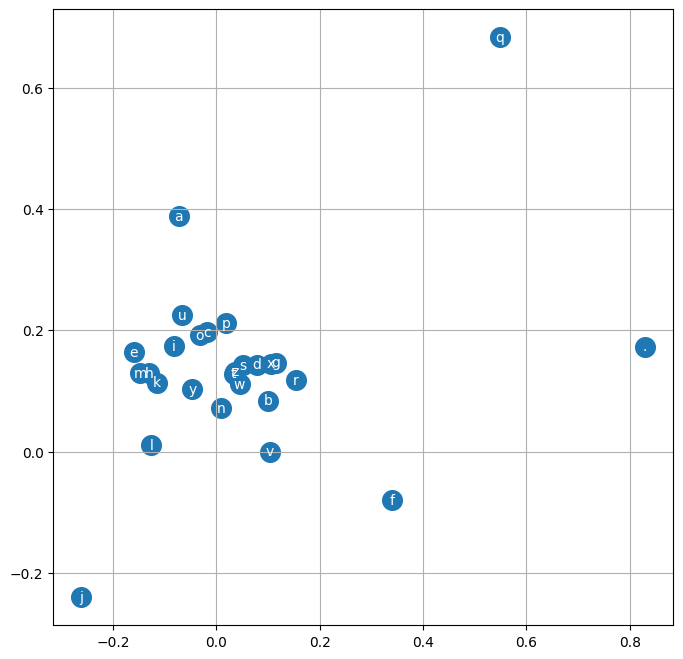

In [177]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center",va="center", color='white')

plt.grid('minor')